In [37]:
import fiona
import numpy as np
import pandas as pd
import panel_processing as pp
import rendering

%load_ext autoreload
%autoreload 2

rendering.set_up()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


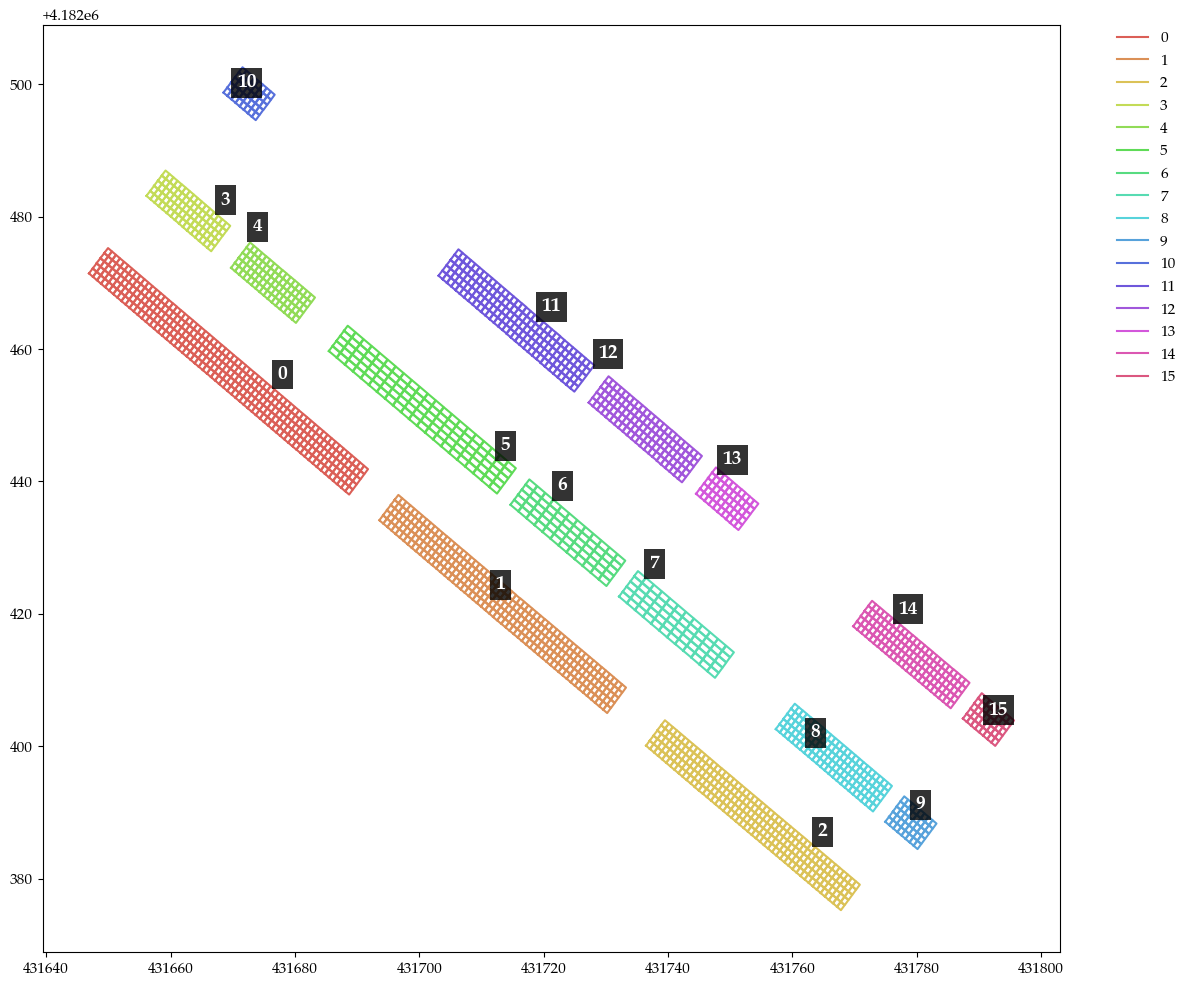

In [38]:
baseline_filename = 'qgis_assets/modulos_automatico_final.shp'
static_filename = 'qgis_assets/modulos_manual_fixed_geometry_new.shp'

_, baseline_panels, _ = pp.load_panels(static_filename, rendering=True)

Current missing panels percentage: 10


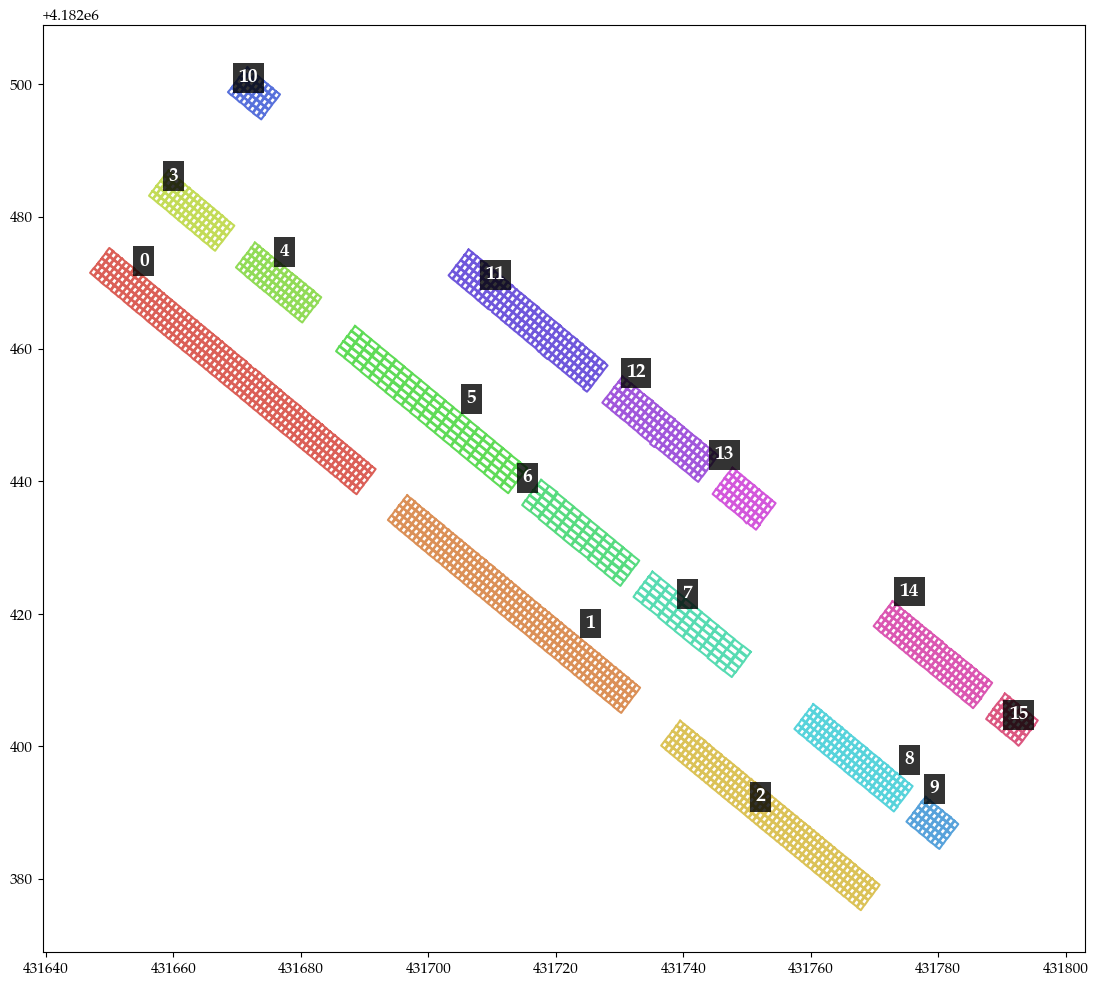

In [41]:
for missing_panels_percentage in range(10, 11, 1):
    print('Current missing panels percentage: ' + str(missing_panels_percentage))

    shp, panels, clusters = pp.load_panels(baseline_filename, rendering=False)
    panels, norm_x = pp.name_panels(shp, clustering_distance=3)

    panels = pp.stress_missing_panels(panels, clusters, nrows=0, missing_panels_p=missing_panels_percentage / 100.0)
    panels = [panel for panel in panels if panel is not None]
    pp.write_panels(baseline_filename.split('.')[0] + '_new.shp', shp, panels)

    shp, panels, clusters = pp.load_panels(baseline_filename.split('.')[0] + '_new.shp', rendering=False)
    panels, _ = pp.name_panels(shp, clustering_distance=3, norm_x=norm_x)
    pp.write_panels(baseline_filename.split('.')[0] + '_new.shp', shp, panels)

    shp, panels, clusters = pp.load_panels(baseline_filename.split('.')[0] + '_new.shp', rendering=False)
    panels = pp.fill_panels(panels, clusters)
    panels = pp.remove_repeated_panels(panels)
    pp.write_panels(baseline_filename.split('.')[0] + '_new.shp', shp, panels)

    shp, _, _ = pp.load_panels(baseline_filename.split('.')[0] + '_new.shp', rendering=False)
    panels, _ = pp.name_panels(shp, clustering_distance=3, norm_x=norm_x)
    pp.write_panels(baseline_filename.split('.')[0] + '_' + str(missing_panels_percentage) + '.shp', shp, panels)
    rendering.plot_panels(panels, color_code=[panel.id_array for panel in panels], draw_text=True, draw_legend=False,
                          savefig='results/test.png')

In [18]:
baseline_panels_centroid = dict()
for panel in baseline_panels:
    baseline_panels_centroid[panel.id_panel] = panel.centroid

percentage_distance = []

for missing_panels_percentage in range(0, 30, 1):
    _, panels, _ = pp.load_panels(baseline_filename.split('.')[0] + '_' + str(missing_panels_percentage) + '.shp', rendering=False)

    panels_centroid = dict()
    for panel in panels:
        panels_centroid[panel.id_panel] = panel.centroid

    # Compute distance between panels
    distance = 0
    for panel_id in baseline_panels_centroid.keys():
        if panel_id in panels_centroid.keys():
            # Compute rmse
            distance += np.sqrt((baseline_panels_centroid[panel_id][0] - panels_centroid[panel_id][0])**2 + (baseline_panels_centroid[panel_id][1] - panels_centroid[panel_id][1])**2)

    percentage_distance.append(distance / len(baseline_panels_centroid.keys()))
    print('Current distance: ' + str(percentage_distance[-1]))

# Fix anomalous values
for i in range(1, len(percentage_distance) - 1):
    if percentage_distance[i] > percentage_distance[i + 1]:
        percentage_distance[i] = (percentage_distance[i - 1] + percentage_distance[i + 1]) / 2.0

Current distance: 0.1860570949073659
Current distance: 0.1868968089355744
Current distance: 0.1875989650940557
Current distance: 0.18850231737629142
Current distance: 0.18941596000970284
Current distance: 0.1901117458352502
Current distance: 0.19115186489050598
Current distance: 0.19172500536650144
Current distance: 0.19310663195976835
Current distance: 0.19358967886744924
Current distance: 0.19476504920031018
Current distance: 0.1949841854454003
Current distance: 0.19626505794159516
Current distance: 0.19761976308345908
Current distance: 0.19836672520784765
Current distance: 0.198709002310397
Current distance: 0.199689036864504
Current distance: 0.2008294396262405
Current distance: 0.2008430779949698
Current distance: 0.20199914893081222
Current distance: 3.932707261365991
Current distance: 0.2042725656309809
Current distance: 0.2052630275819665
Current distance: 0.20588727567800322
Current distance: 0.20638454806250245
Current distance: 0.20687239099112603
Current distance: 0.2084015

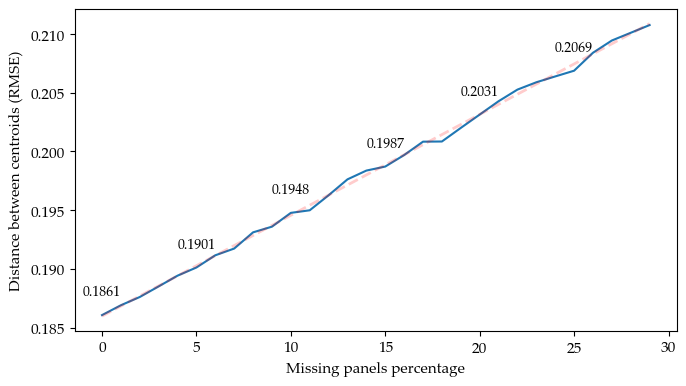

In [36]:
# Plot
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.figure(figsize=(7, 4))
plt.plot(range(0, 30, 1), percentage_distance)
plt.xlabel('Missing panels percentage')
plt.ylabel('Distance between centroids (RMSE)')
# Plot lineal regression
reg = LinearRegression().fit(np.array(range(0, 30, 1)).reshape(-1, 1), np.array(percentage_distance).reshape(-1, 1))
plt.plot(range(0, 30, 1), reg.predict(np.array(range(0, 30, 1)).reshape(-1, 1)), color='red', linewidth=2, linestyle='--', alpha=0.2)
# Plot text every 5 points with only 2 decimals
for i in range(0, 30, 5):
    plt.text(i, percentage_distance[i] + 0.002, str(round(percentage_distance[i], 4)), fontsize=10, horizontalalignment='center', verticalalignment='center')
plt.tight_layout()
plt.savefig('results/centroid_distance.png', dpi=500)
plt.show()